In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath("__file__"))))
sys.path.append(parentdir)

from joblib import Parallel, delayed
import numpy as np
import pickle 
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchmetrics
import seaborn as sns
import glob
import dask.dataframe as dd
from tqdm import tqdm
from copy import deepcopy
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score
from pathlib import Path

from torchmetrics import MatthewsCorrCoef, F1Score, Accuracy, Precision, Recall
from sklearn.utils import resample
from scipy.stats import median_abs_deviation as mad
import time
import cmcrameri.cm as cmc
import matplotlib.colors as clr
from matplotlib.ticker import MultipleLocator, LinearLocator, AutoMinorLocator
plt.rcParams["grid.linestyle"] =  ":"
plt.rcParams["axes.edgecolor"] = "gray"
plt.rcParams["axes.linewidth"] = 0.7

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
#sns.set_context("notebook", font_scale=1.2)
#import scienceplots
#plt.style.use(["science", "nature"])


if Path.home().name == "nikolaibeckjensen":
    DATA_ROOT = Path.home() / "Library" / "CloudStorage" / "OneDrive-DanmarksTekniskeUniversitet" / "Virk2Vec" / "data"
elif Path.home().name == "annabramslow":
    DATA_ROOT = Path.home() / "Library" / "CloudStorage" / "OneDrive-DanmarksTekniskeUniversitet(2)" / "Virk2Vec" / "data"

/Users/nikolaibeckjensen/Company2Vec/myenv2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


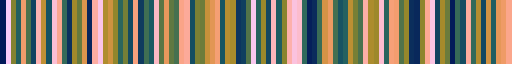

In [2]:
cmap = cmc.batlowS
cmap

In [3]:
v = "4.02"
#v= "6.3"
save_path = r"../analysis/plots/%s/" %v

In [4]:
def load_stats(path):
    data = {}
    with open(path + "prb.npy", "rb") as f:
        data["prb"] = np.load(f).astype(np.float32)
    with open(path + "trg.npy", "rb") as f:
        data["trg"] = np.load(f)
    with open(path + "id.npy", "rb") as f:
        data["id"] = np.load(f)
    return data
def load_stats2(path):
    data = {}
    with open(path + "prb.npy", "rb") as f:
        data["prb"] = np.load(f).astype(np.float32)
        data["prb"] = data["prb"][:,1]
    with open(path + "trg.npy", "rb") as f:
        data["trg"] = np.load(f)
    return data
     

def metrics_parallel(metrics, preds, targs):
    return metrics(preds, targs).numpy()

def return_auc(preds, targs):
    metric = torchmetrics.AUROC(num_classes=2)
    return metric(preds, targs).numpy().item()

def return_mcc(preds, targs):
    metric = MatthewsCorrCoef(num_classes=2)
    return metric(preds, targs).numpy().item()

def return_acc(preds, targs):
    metric = Accuracy(num_classes=2, average="macro", multiclass=True)
    return metric(preds, targs).numpy().item()

def return_f1(preds, targs):
    metric = F1Score(num_classes=2, task='binary')
    return metric(preds, targs).numpy().item()

def return_precision(preds, targs):
    metric = Precision(num_classes=2, task='binary')
    return metric(preds, targs).numpy().item()

def return_recall(preds, targs):
    metric = Recall(num_classes=2, task='binary')
    return metric(preds, targs).numpy().item()

def bootstrap_mcc(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.05):
    ids = np.arange(0, targs.shape[0], 1)
    metric = MatthewsCorrCoef(num_classes=2,threshold=0.50)
    idx = list()

    for n in range(n_bootstraps):
        i  = resample(ids, stratify=targs.numpy(), random_state=n)
        if len(np.unique(targs[i])) < 2:
                continue
        idx.append(i)

    scores = []
    for i in idx:
        score = metric(preds[i], targs[i])
        scores.append(score)
    scores = np.array(scores)
    
    return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}

def bootstrap_precision(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.05):
    ids = np.arange(0, targs.shape[0], 1)
    metric = Precision(task='binary')
    idx = list()

    for n in range(n_bootstraps):
        i  = resample(ids, stratify=targs.numpy(), random_state=n)
        if len(np.unique(targs[i])) < 2:
                continue
        idx.append(i)

    scores = []
    for i in idx:
        score = metric(preds[i], targs[i])
        scores.append(score)
    scores = np.array(scores)
    
    return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}


def bootstrap_recall(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.05):
    ids = np.arange(0, targs.shape[0], 1)
    metric = Recall(task='binary')
    idx = list()

    for n in range(n_bootstraps):
        i  = resample(ids, stratify=targs.numpy(), random_state=n)
        if len(np.unique(targs[i])) < 2:
                continue
        idx.append(i)

    scores = []
    for i in idx:
        score = metric(preds[i], targs[i])
        scores.append(score)
    scores = np.array(scores)
    
    return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}


def bootstrap_f1(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.05):
    ids = np.arange(0, targs.shape[0], 1)
    metric = F1Score(num_classes=2, task='binary')
    idx = list()

    for n in range(n_bootstraps):
        i  = resample(ids, stratify=targs.numpy(), random_state=n)
        if len(np.unique(targs[i])) < 2:
                continue
        idx.append(i)

    scores = []
    for i in idx:
        score = metric(preds[i], targs[i])
        scores.append(score)
    scores = np.array(scores)
    
    return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}

def bootstrap_acc(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.05):
    ids = np.arange(0, targs.shape[0], 1)
    metric = Accuracy(task='binary')
    idx = list()

    for n in range(n_bootstraps):
        i  = resample(ids, stratify=targs.numpy(), random_state=n)
        if len(np.unique(targs[i])) < 2:
                continue
        idx.append(i)

    scores = []
    for i in idx:
        score = metric(preds[i], targs[i])
        scores.append(score)
    scores = np.array(scores)
    
    return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}

def return_stats(path: str):
    x  = load_stats(path)
    start = time.time()
    x["auc"] = return_auc(preds = torch.from_numpy(x["prb"]),  
              targs = torch.from_numpy(x["trg"]).long()) 

    print("AUC is done: %.2f s" %(time.time()-start))
    print(x["auc"])
    start = time.time()
    x["mcc"] = bootstrap_mcc(preds = torch.from_numpy(x["prb"]),  
              targs = torch.from_numpy(x["trg"]).long(), 
              n_bootstraps=1000)
    print("MCC is done: %.2f s" %(time.time()-start))
    print(x["mcc"])

    start = time.time()
    
    x["f1"] = bootstrap_f1(preds = torch.from_numpy(x["prb"]),  
              targs = torch.from_numpy(x["trg"]).long(), 
              n_bootstraps=1000)
    print("F1 is done: %.2f s" %(time.time()-start))
    print(x["f1"])

    start = time.time()
    x["precision"] = bootstrap_precision(preds = torch.from_numpy(x["prb"]),  
              targs = torch.from_numpy(x["trg"]).long(), 
              n_bootstraps=1000)
    print("Precision is done: %.2f s" %(time.time()-start))
    print(x["precision"])

    start = time.time()

    x["recall"] = bootstrap_recall(preds = torch.from_numpy(x["prb"]),  
              targs = torch.from_numpy(x["trg"]).long(), 
              n_bootstraps=1000)
    print("Recall is done: %.2f s" %(time.time()-start))
    print(x["recall"])

    return x

def contains_in_sequence(sample, min_, max_):
    """Checks if sequence contains tokens in range [min_, max_]"""
    return np.where((sample >= min_) & (sample <=max_))[0].shape[0] > 0

In [5]:
task = "employee" # either moving, capital, employee, bankruptcy
model_path = f"/Users/nikolaibeckjensen/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Virk2Vec/predictions/{task}/company2vec/"
save_path = f"/Users/nikolaibeckjensen/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Virk2Vec/figures/prediction_subsets/{task}/"

population_map = {'capital' : 'capital_increase', 
                  "employee" : "employee_level", 
                  "moving" : "moving_min_emp", 
                  "bankruptcy" : "bankruptcy"}

corpus_map = {'capital' : 'capital_set', 
              "employee" : "employee_set", 
              "moving" : "moving_set_min_emp", 
              "bankruptcy" : "bankruptcy_set"}

plot_name_map = {'capital' : 'Capital Increases', 
              "employee" : "Employee Level", 
              "moving" : "Address Changes", 
              "bankruptcy" : "Bankruptcies"}

population_name = population_map[task]
corpus_name = corpus_map[task]
plot_name = plot_name_map[task]

In [6]:
from sklearn.preprocessing import LabelBinarizer
if task == "employee":
    def load_stats(path):
        data = {}
        with open(path + "prb.npy", "rb") as f:
            data["prb"] = np.load(f).astype(np.float32)
        #check if prb is multiclass and is int values, then convert to onehot
        if len(np.unique(data["prb"])) == 3 and np.all(np.equal(np.mod(data["prb"], 1), 0)):
            data["prb"] = LabelBinarizer().fit_transform(data["prb"]).astype(np.float32)
        with open(path + "trg.npy", "rb") as f:
            data["trg"] = np.load(f)
        #with open(path + "id.npy", "rb") as f:
        #    data["id"] = np.load(f)
        with open(path + "id.npy", "rb") as f:
            data["id"] = np.load(f)
        return data
    def metrics_parallel(metrics, preds, targs):
        return metrics(preds, targs).numpy()

    def return_auc(preds, targs):
        metric = torchmetrics.AUROC(num_classes=3)
        return metric(preds, targs).numpy().item()

    def return_mcc(preds, targs):
        metric = MatthewsCorrCoef(num_classes=3, task='multiclass')
        return metric(preds, targs).numpy().item()

    # def return_acc(preds, targs):
    #     metric = Accuracy(num_classes=3, average="macro", multiclass=True, top_k=1)
    #     return metric(preds, targs).numpy().item()

    def return_f1(preds, targs):
        metric = F1Score(num_classes=3, task='multiclass',top_k=1, average="macro")
        return metric(preds, targs).numpy().item()

    def return_precision(preds, targs):
        metric = Precision(num_classes=3, task='multiclass', top_k=1, average="macro")
        return metric(preds, targs).numpy().item()

    def return_recall(preds, targs):
        metric = Recall(num_classes=3, task='multiclass', top_k=1, average="macro")
        return metric(preds, targs).numpy().item()

    def bootstrap_mcc(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.05):
        ids = np.arange(0, targs.shape[0], 1)
        metric = MatthewsCorrCoef(num_classes=3,threshold=0.505)
        idx = list()

        for n in range(n_bootstraps):
            i  = resample(ids, stratify=targs.numpy(), random_state=n)
            if len(np.unique(targs[i])) < 2:
                    continue
            idx.append(i)

        scores = []
        for i in idx:
            score = metric(preds[i], targs[i])
            scores.append(score)
        scores = np.array(scores)
        
        return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}

    def bootstrap_precision(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.05):
        ids = np.arange(0, targs.shape[0], 1)
        metric = Precision(task='multiclass', top_k=1, average="macro", num_classes=3)
        idx = list()

        for n in range(n_bootstraps):
            i  = resample(ids, stratify=targs.numpy(), random_state=n)
            if len(np.unique(targs[i])) < 2:
                    continue
            idx.append(i)

        scores = []
        for i in idx:
            score = metric(preds[i], targs[i])
            scores.append(score)
        scores = np.array(scores)
        
        return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}


    def bootstrap_recall(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.05):
        ids = np.arange(0, targs.shape[0], 1)
        metric = Recall(task='multiclass', top_k=1, average="macro", num_classes=3)
        idx = list()

        for n in range(n_bootstraps):
            i  = resample(ids, stratify=targs.numpy(), random_state=n)
            if len(np.unique(targs[i])) < 2:
                    continue
            idx.append(i)

        scores = []
        for i in idx:
            score = metric(preds[i], targs[i])
            scores.append(score)
        scores = np.array(scores)
        
        return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}


    def bootstrap_f1(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.05):
        ids = np.arange(0, targs.shape[0], 1)
        metric = F1Score(num_classes=3, task='multiclass', top_k=1, average="macro")
        idx = list()

        for n in range(n_bootstraps):
            i  = resample(ids, stratify=targs.numpy(), random_state=n)
            if len(np.unique(targs[i])) < 2:
                    continue
            idx.append(i)

        scores = []
        for i in idx:
            score = metric(preds[i], targs[i])
            scores.append(score)
        scores = np.array(scores)
        
        return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}


In [7]:
data = {}
data["c2v"] = return_stats(model_path)
mcc_mean = data["c2v"]["mcc"]["mean"]

/Users/nikolaibeckjensen/Company2Vec/myenv2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


AUC is done: 0.06 s
0.6343560814857483
MCC is done: 3.99 s
{'mean': 0.1734258085489273, 'lower': 0.15851093381643294, 'upper': 0.18850365914404393}
F1 is done: 3.56 s
{'mean': 0.4479524493217468, 'lower': 0.4379439249634743, 'upper': 0.4580059707164764}
Precision is done: 3.51 s
{'mean': 0.45133817195892334, 'lower': 0.441195584833622, 'upper': 0.4616219520568848}
Recall is done: 3.50 s
{'mean': 0.4481390714645386, 'lower': 0.43822058439254763, 'upper': 0.4581475451588631}


In [8]:
if task == "moving":

    # make histogram of the output probabilities
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.hist(data["c2v"]["prb"], bins=100, color="lightslategray", alpha=0.7, edgecolor='white')
    ax.set_xlabel("Predicted Probability")
    ax.set_ylabel("Frequency")
    ax.set_xlim(0, 1)
    ax.set_title("Predicted Probabilities For Moving")
    sns.despine()
    plt.tight_layout()
    plt.savefig(save_path + "probabilities.png", dpi=300)
    plt.show()


## 1. Breakdown by subsets

In [9]:
def get_employee_counts(test_cvrs, _period_start='2022-01-01' ) -> list:
    """ Returns a list of CVRs that satisfy the employee filter """
    _period_start = pd.to_datetime(_period_start)

    # get the financials data 
    employee_path = DATA_ROOT / "Tables" / "EmployeeCounts"
    employees_csv = [file for file in employee_path.iterdir() if file.is_file() and file.suffix == '.csv']
    df_employees = dd.read_csv(
        employees_csv,
        usecols=['CVR', 'FromDate', 'EmployeeCounts'],
        on_bad_lines="error",
        assume_missing=True,
        dtype={
                "CVR": int,
                "FromDate": str,
                "EmployeeCounts": float,
            },
        blocksize="256MB"
    ).compute()

    # apply filters on the annual reports in the year up until the cutoff date, take the most recent employee entry
    df_employees['FromDate'] = pd.to_datetime(df_employees['FromDate'], errors='coerce')
    df_employees = df_employees.loc[(df_employees.FromDate < _period_start) & (df_employees.FromDate >= _period_start - pd.DateOffset(years=1))]
    df_employees = df_employees.sort_values(by=['CVR', 'FromDate'], ascending=False).drop_duplicates(subset='CVR', keep='first')
    
    df = pd.DataFrame({'CVR': test_cvrs})
    df = df.merge(df_employees, on='CVR', how='left').fillna(0)

    return df.drop(columns=['FromDate']).set_index("CVR")

def cvrs_satisfying_registration(test_cvrs, registration_type, _period_start='2022-01-01' ) -> list:
        """ Returns a list of CVRs and their latest registration at the cutoff date (_period_start).
        Args:
            registration_type (str): The type of registration to filter on Either 'Status', 'Industry', 'CompanyType']
         """
        _period_start = pd.to_datetime(_period_start)

        # return empty list if no filter is set
        if registration_type not in ['Status', 'Industry', 'CompanyType']:
            raise ValueError(f"No filter set for registration type: {registration_type}")

        print(f"Filtering on registration type: {registration_type}")

        registrations_path = DATA_ROOT / "Tables" / "Registrations"
        registrations_csv = [file for file in registrations_path.iterdir() if file.is_file() and file.suffix == '.csv']
        df_registrations = dd.read_csv(
            registrations_csv,
            usecols=["CVR", "FromDate", "ChangeType", "NewValue"],
            on_bad_lines="error",
            assume_missing=True,
            dtype={
                "CVR": int,
                "FromDate": str,
                "ChangeType": str,
                "NewValue": str
            },
            blocksize="256MB"
        ).compute()

        # filter to show industry changes
        df_registrations = df_registrations.loc[df_registrations.ChangeType == registration_type]
        df_registrations['FromDate'] = pd.to_datetime(df_registrations['FromDate'], errors='coerce')
        df_registrations = df_registrations.dropna(subset=['FromDate']).sort_values(by='FromDate')
        population = pd.DataFrame({'CVR': test_cvrs})
        population['cutoff_date'] = _period_start

        # merge asof values and filter
        merged = pd.merge_asof(population, df_registrations, left_on='cutoff_date', right_on='FromDate', by='CVR')
        
        # if registration_type == 'Industry':
        #     merged['industry4digit'] = merged['NewValue'].str[:4]
        #     cvrs_in_criteria = merged.loc[merged.industry4digit.isin(self._industry_filters)].CVR.to_numpy()
        # else:
        #     cvrs_in_criteria = merged.loc[merged.NewValue.isin(filter[registration_type])].CVR.to_numpy()

        return merged[['CVR', 'NewValue']].set_index("CVR").rename(columns={"NewValue": registration_type})

industry_dict = {1: 'Landbrug, skovbrug og fiskeri',
                    2: 'Industri, råstofindvinding og forsyningsvirksomhed',
                    3: 'Bygge og anlæg',
                    4: 'Handel og transport',
                    5: 'Information og kommunikation',
                    6: 'Finansiering og forsikring',
                    7: 'Ejendomshandel og udlejning',
                    8: 'Erhvervsservice',
                    9: 'Offentlig administration, undervisning og sundhed',
                    10: 'Kultur, fritid og anden service',
                    11: 'Uoplyst aktiviteter'}


def compute_industry_category(industry_code):
    if int(industry_code[:2]) < 5:
        return 1
    elif int(industry_code[:2]) < 41:
        return 2
    elif int(industry_code[:2]) < 45:
        return 3
    elif int(industry_code[:2]) < 58:
        return 4
    elif int(industry_code[:2]) < 64:
        return 5
    elif int(industry_code[:2]) < 68:
        return 6
    elif int(industry_code[:2]) < 69:
        return 7
    elif int(industry_code[:2]) < 84:
        return 8
    elif int(industry_code[:2]) < 99:
        return 9
    elif int(industry_code[:2]) <= 99 and industry_code != 999999:
        return 10
    else:
        return 11

def discrete_employee(x):
    if x == 0:
        return "[0]"
    elif x <= 1:
        return "]0, 1]"
    elif x <= 10:
        return "]1, 10]"
    else:
        return ">10"
    
def discrete_employee2(x):
    """use for the employee task where there has already been filtered to 2+ employees"""
    if x <= 10:
        return "[2, 10]"
    elif x <= 20:
        return "]10, 20]"
    else:
        return ">20"


def discrete_age(x):
    if x <= 1:
        return "[0, 1]"
    elif x <= 5:
        return "]1, 5]"
    elif x <= 10:
        return "]5, 10]"
    else:
        return ">10"

In [10]:
emp_counts = get_employee_counts(test_cvrs=data['c2v']['id'], _period_start='2022-01-01' )
industries = cvrs_satisfying_registration(test_cvrs=data['c2v']['id'], registration_type='Industry', _period_start='2022-01-01')
company_types = cvrs_satisfying_registration(test_cvrs=data['c2v']['id'], registration_type='CompanyType', _period_start='2022-01-01')

industries['Industry'] = industries['Industry'].apply(lambda x: compute_industry_category(x))

Filtering on registration type: Industry
Filtering on registration type: CompanyType


In [11]:
# compute sequence length + maybe age?
corpus_path = f'/Users/nikolaibeckjensen/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Virk2Vec/data/processed/corpus/{corpus_name}/sentences/test/'
df = dd.read_parquet(corpus_path).compute()
df = df[~df["AFTER_THRESHOLD"]]
df["LENGTH"] = df["SENTENCE"].apply(lambda x: len(x.split()))
seqlen = df.groupby("CVR")["LENGTH"].sum().reset_index()
age = df.groupby("CVR")["AGE"].max().reset_index()
seqlen["SEQLEN"] = seqlen["LENGTH"].apply(lambda x: np.minimum(x, 2560))
seqlen = seqlen.drop(columns=["LENGTH"])

In [12]:
population_path = DATA_ROOT / "processed" / "populations" / population_name / "population" / "result.pkl"
ppl = pd.read_pickle(population_path)
result = pd.DataFrame({"CVR": data["c2v"]["id"].astype(int)}).set_index("CVR")
result["PRED"] = list(data["c2v"]["prb"])
result = result.join(ppl, how="left")
result = result.join(emp_counts, how="left")
result = result.join(industries, how="left")
result = result.join(company_types, how="left")
result = result.join(seqlen.set_index("CVR"), how="left")
result = result.join(age.set_index("CVR"), how="left")
if task != "employee":
    result["EMPLOYEES"] = result["EmployeeCounts"].apply(lambda x: discrete_employee(x))
else:
    result["EMPLOYEES"] = result["EmployeeCounts"].apply(lambda x: discrete_employee2(x))

result['AGE'] = result['AGE'].apply(lambda x: discrete_age(x))


ec_q = np.quantile(result["SEQLEN"].values, [0, 0.33, 0.66, 1.])
result["SEQLEN"] = pd.cut(result["SEQLEN"], bins = ec_q,
                               include_lowest=True, labels=False)

#result["UNLABELED"] = result.apply(lambda x: (x["TARGET"] == 0) & (x["EVENT_FINAL_DATE"] < pd.to_datetime("2020-12-31", format="%Y-%m-%d")), axis = 1)
#result["YEAR"] = result["EVENT_FINAL_DATE"].dt.year

In [13]:
seq_len0 = f"[{int(ec_q[0])}, {int(ec_q[1])}["
seq_len1 = f"[{int(ec_q[1])}, {int(ec_q[2])}["
seq_len2 = f"[{int(ec_q[2])}, {int(ec_q[3])}]"

In [14]:
groups = {
        "]0, 1]": result["EMPLOYEES"] == "]0, 1]",
        "]1, 10]": result["EMPLOYEES"] == "]1, 10]",
        ">10": result["EMPLOYEES"] == ">10",
        #"IVS": result["CompanyType"] == "IVS",
        "APS": result["CompanyType"] == "APS",
        "A/S": result["CompanyType"] == "A/S",
        "1" : result["Industry"] == 1,
        "2" : result["Industry"] == 2,
        "3" : result["Industry"] == 3,
        "4" : result["Industry"] == 4,
        "5" : result["Industry"] == 5,
        "6" : result["Industry"] == 6,
        "7" : result["Industry"] == 7,
        "8" : result["Industry"] == 8,
        "9" : result["Industry"] == 9,
        seq_len0 : result["SEQLEN"] == 0,
        seq_len1 : result["SEQLEN"] == 1,
        seq_len2 : result["SEQLEN"] == 2,
        "[0, 1]": result["AGE"] == "[0, 1]",
        "]1, 5]": result["AGE"] == "]1, 5]",
        "]5, 10]": result["AGE"] == "]5, 10]",
        ">10": result["AGE"] == ">10",
}
if task != "moving":
    groups["[0]"] = result["EMPLOYEES"] == "[0]"

if task == "employee":
   # adjust to the v2 of employee discretization by removing the initial and adding the new
    groups = {
        "[2, 10]" : result["EMPLOYEES"] == "[2, 10]",
        "]10, 20]" : result["EMPLOYEES"] == "]10, 20]",
        ">20" : result["EMPLOYEES"] == ">20",
        #"IVS": result["CompanyType"] == "IVS",
        "APS": result["CompanyType"] == "APS",
        "A/S": result["CompanyType"] == "A/S",
        "1" : result["Industry"] == 1,
        "2" : result["Industry"] == 2,
        "3" : result["Industry"] == 3,
        "4" : result["Industry"] == 4,
        "5" : result["Industry"] == 5,
        "6" : result["Industry"] == 6,
        "7" : result["Industry"] == 7,
        "8" : result["Industry"] == 8,
        "9" : result["Industry"] == 9,
        seq_len0 : result["SEQLEN"] == 0,
        seq_len1 : result["SEQLEN"] == 1,
        seq_len2 : result["SEQLEN"] == 2,
        #"[0, 1]": result["AGE"] == "[0, 1]",
        #"]1, 5]": result["AGE"] == "]1, 5]",
        #"]5, 10]": result["AGE"] == "]5, 10]",
        #">10": result["AGE"] == ">10",
}



In [15]:
unitary_mcc = {}
unitary_prb = {}
unitary_cnt = {}

for k, condition in groups.items():
    preds = result[condition]["PRED"].values
    targs = result[condition]["TARGET"].values
    if task == "employee":
        preds = np.vstack(preds)
        print(len(preds))
        unitary_mcc[k] = bootstrap_mcc(torch.from_numpy(preds).float(), torch.from_numpy(targs.to_numpy()).long())
        unitary_cnt[k] = {"stable" : np.sum(targs == 0), "increase" : np.sum(targs == 1), "decrease" : np.sum(targs == 2), "total": preds.shape[0]}
    else:
        unitary_mcc[k] = bootstrap_mcc(torch.from_numpy(preds).float(), torch.from_numpy(targs.to_numpy()).long())
        unitary_prb[k] = {"median": np.median(preds), "mad": mad(preds)}
        unitary_cnt[k] = {"total": preds.shape[0], "positive": np.sum(targs.to_numpy())}
    print("Done:", k)

6545
Done: [2, 10]
1271
Done: ]10, 20]
1433
Done: >20
6578
Done: APS
2665
Done: A/S
187
Done: 1
963
Done: 2
1524
Done: 3
3283
Done: 4
688
Done: 5
197
Done: 6
259
Done: 7
1546
Done: 8
602
Done: 9
3057
Done: [10, 400[
3050
Done: [400, 594[
3142
Done: [594, 1373]


In [16]:
def return_stats(labels, prb_dict, count_dict,  mcc_dict, title:str, figsize=(10,10), save_folder="", name='Bankruptcies'):
    mu, var, err = [], [], []
    padding = 0.5

    for label in labels:
        mu.append(prb_dict[label]["median"])
        var.append(prb_dict[label]["mad"])
        err.append([mu[-1] - var[-1], mu[-1] + var[-1]])
    
    fig, ax = plt.subplots(2,2, figsize=figsize)

    #### MEDIAN PRB
    ax[0,0].errorbar(y = labels, x = mu, xerr = var, fmt="o",
                     capsize=5, ecolor="dimgray", ms=3.5,
                     elinewidth=2, mfc="black", mec="black")
    
    ax[0,0].set_xlabel(f"Median Probability of {name}")
    ax[0,0].set_ylabel("%s" %title)
    ax[0,0].set_title(f"Median Probability of  {name} per %s" %title)

    ax[0,0].tick_params(axis= "x", which="major", width= 1, length = 6, direction="out", color="gray")
    ax[0,0].tick_params(axis= "x", which="minor", width= 1, length = 3, direction="out", color="gray")
    ax[0,0].tick_params(axis= "y", which="both", width=0, length =0)

    ax[0,0].xaxis.set_major_locator(MultipleLocator(0.1))
    ax[0,0].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0,0].set_ylim(-padding, len(labels) - 1 + padding)
    ax[0,0].set_xlim([0, 1.])
    #### POSITIVE COUNT
    count = list()
    for label in labels:
        count.append(count_dict[label]["positive"])

    ax[0,1].barh(y = labels, height = 0.5,  
        width=count,  edgecolor="none", facecolor="silver")
    ax[0,1].set_xlabel(f"Number of {name}")
    ax[0,1].set_ylabel("%s" %title)
    ax[0,1].set_title(f"Number of {name} per %s" %title)

    ax[0,1].tick_params(axis= "x", which="major", width= 1, length = 6, direction="out", color="gray")
    ax[0,1].tick_params(axis= "x", which="minor", width= 1, length = 3, direction="out", color="gray")
    ax[0,1].tick_params(axis= "y", which="both", width=0, length =0)

    ax[0,1].xaxis.set_major_locator(MultipleLocator(500))
    ax[0,1].xaxis.set_minor_locator(AutoMinorLocator(5))

    ### POPULATION COUNTS
    count = list()
    for label in labels:
        count.append(count_dict[label]["total"])
    ax[1,0].barh(y = labels, height = 0.5, label = "negative",  width=count, facecolor="silver", edgecolor="none")
    count = list()
    for label in labels:
        count.append(count_dict[label]["positive"]) #+ count_dict[label]["unlabeled"])
    
    #ax[1,0].barh(y = labels, height = 0.5, label= "unlabeled",  width=count, facecolor="orange", edgecolor="none")
    count = list()
    for label in labels:
        count.append(count_dict[label]["positive"])
    ax[1,0].barh(y = labels, height = 0.5, label= "positive",  width=count, facecolor="dimgray", edgecolor="none")


    ax[1,0].set_xlabel("Number of Companies")
    ax[1,0].set_ylabel("%s" %title)
    ax[1,0].set_title(f"Number of {name} per {title}")
    ax[1,0].tick_params(axis= "x", which="major", width=1, length = 6, direction="out", color="gray")
    ax[1,0].tick_params(axis= "x", which="minor", width=1, length =3, direction="out", color="gray")
    ax[1,0].tick_params(axis= "y", which="both", width=0, length =0)
    xlim = np.max([ax[1,0].get_xlim()[1], 10100])
    ax[1,0].set_xlim([0, xlim])
    if xlim < 35000:
        ax[1,0].xaxis.set_major_locator(MultipleLocator(5000))
    else:
        ax[1,0].xaxis.set_major_locator(MultipleLocator(15000))

    ax[1,0].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[1,0].legend()
    
    mu, var, err = [], [], []

    for label in labels:
        mu.append(mcc_dict[label]["mean"])
        var.append(mcc_dict[label]["upper"])
        err.append([np.abs(mu[-1] - mcc_dict[label]["lower"]), np.abs(mu[-1] - mcc_dict[label]["upper"])])
        

    ax[1,1].errorbar(y = labels,  
        xerr= np.array(err).T, x= mu, fmt="o",
                     capsize=5, ecolor="dimgray", ms=3.5,
                     elinewidth=2, mfc="black", mec="black")
    ax[1,1].set_xlabel("MCC Score")
    ax[1,1].set_ylabel("%s" %title)
    ax[1,1].set_title("MCC per %s" %title)
    xlim = np.max([np.max(var) + 0.05, 0.8])
    ax[1,1].set_xlim([-0.1, xlim])
    ax[1,1].set_ylim([-padding, len(labels)-1+padding])
    ax[1,1].axvline(0.0, color="gray", linewidth=0.5, linestyle= ":")
    ax[1,1].axvline(mcc_mean, color="blue", linewidth=1, linestyle= ":")


    ax[1,1].tick_params(axis= "x", which="major", width=1, length = 6, direction="out", color="gray")
    ax[1,1].tick_params(axis= "x", which="minor", width=1, length =3, direction="out", color="gray")
    ax[1,1].tick_params(axis= "y", which="both", width=0, length =0)

    ax[1,1].xaxis.set_major_locator(MultipleLocator(0.1))
    ax[1,1].xaxis.set_minor_locator(AutoMinorLocator(5))
    return fig, ax

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator, AutoMinorLocator


def plot_median_prb(labels, prb_dict, title, name, figsize, save_folder, figname, task):
    mu, var, err = [], [], []
    padding = 0.5

    for label in labels:
        mu.append(prb_dict[label]["median"])
        var.append(prb_dict[label]["mad"])
        err.append([mu[-1] - var[-1], mu[-1] + var[-1]])

    fig, ax = plt.subplots(figsize=figsize)
    ax.errorbar(y=labels, x=mu, xerr=var, fmt="o",
                capsize=5, ecolor="dimgray", ms=3.5,
                elinewidth=2, mfc="black", mec="black")
    ax.set_xlabel(f"Median Probability of {name}")
    ax.set_ylabel(f"{title}")
    ax.set_title(f"Median Probability of {name} per {title}")
    ax.tick_params(axis="x", which="major", width=1, length=6, direction="out", color="gray")
    ax.tick_params(axis="x", which="minor", width=1, length=3, direction="out", color="gray")
    ax.tick_params(axis="y", which="both", width=0, length=0)
    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.set_ylim(-padding, len(labels) - 1 + padding)
    ax.set_xlim([0, 1.])
    plt.tight_layout()
    fig.savefig(save_folder + f"{figname}_median_prb_{task}.png", format="png", dpi=300, bbox_inches="tight")
    plt.close(fig)

def plot_positive_count(labels, count_dict, title, name, figsize, save_folder, figname, task):
    count = [count_dict[label]["positive"] for label in labels]
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(y=labels, height=0.5, width=count, edgecolor="none", facecolor="silver")
    ax.set_xlabel(f"Number of {name}")
    ax.set_ylabel(f"{title}")
    ax.set_title(f"Number of {name} per {title}")
    ax.tick_params(axis="x", which="major", width=1, length=6, direction="out", color="gray")
    ax.tick_params(axis="x", which="minor", width=1, length=3, direction="out", color="gray")
    ax.tick_params(axis="y", which="both", width=0, length=0)
    ax.xaxis.set_major_locator(MultipleLocator(500))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tight_layout()
    fig.savefig(save_folder + f"{figname}_positive_count_{task}.png", format="png", dpi=300, bbox_inches="tight")
    plt.close(fig)

def plot_population_counts(labels, count_dict, title, name, figsize, save_folder, figname, task, binary=True):
    fig, ax = plt.subplots(figsize=figsize)
    total_count = [count_dict[label]["total"] for label in labels]
    if not binary:
        # use only for employees, either stable, increase of decrease
        stable_count = [count_dict[label]["stable"] for label in labels]
        increase_count = [count_dict[label]["increase"] for label in labels]
        decrease_count = [count_dict[label]["decrease"] for label in labels]
        ax.barh(y=labels, height=0.5, width=total_count, label="stable", facecolor="silver", edgecolor="none")
        ax.barh(y=labels, height=0.5, width=increase_count, label="increase", facecolor="rosybrown", edgecolor="none", left=stable_count)
        ax.barh(y=labels, height=0.5, width=decrease_count, label="decrease", facecolor="black", edgecolor="none", left=np.array(stable_count) + np.array(increase_count))
    else:
        positive_count = [count_dict[label]["positive"] for label in labels]
        ax.barh(y=labels, height=0.5, width=total_count, label="negative", facecolor="silver", edgecolor="none")
        ax.barh(y=labels, height=0.5, width=positive_count, label="positive", facecolor="dimgray", edgecolor="none")
    ax.set_xlabel("Number of Companies")
    ax.set_ylabel(f"{title}")
    if binary:
        ax.set_title(f"Number of {name} per {title}")
    else:
        ax.set_title(f"Employee Targets per {title}")
    ax.tick_params(axis="x", which="major", width=1, length=6, direction="out", color="gray")
    ax.tick_params(axis="x", which="minor", width=1, length=3, direction="out", color="gray")
    ax.tick_params(axis="y", which="both", width=0, length=0)
    xlim = np.max([ax.get_xlim()[1], 10100])
    ax.set_xlim([0, xlim])
    if xlim < 35000:
        ax.xaxis.set_major_locator(MultipleLocator(5000))
    else:
        ax.xaxis.set_major_locator(MultipleLocator(15000))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.legend()
    plt.tight_layout()
    fig.savefig(save_folder + f"{figname}_population_counts_{task}.png", format="png", dpi=300, bbox_inches="tight")
    plt.close(fig)

def plot_mcc_score(labels, mcc_dict, title, name, figsize, save_folder, figname, task):
    mu, var, err = [], [], []
    padding = 0.5

    for label in labels:
        mu.append(mcc_dict[label]["mean"])
        var.append(mcc_dict[label]["upper"])
        err.append([np.abs(mu[-1] - mcc_dict[label]["lower"]), np.abs(mu[-1] - mcc_dict[label]["upper"])])

    fig, ax = plt.subplots(figsize=figsize)
    ax.errorbar(y=labels, xerr=np.array(err).T, x=mu, fmt="o",
                capsize=5, ecolor="dimgray", ms=3.5,
                elinewidth=2, mfc="black", mec="black", label="95% CI (boostrap)")
    ax.set_xlabel("MCC Score")
    ax.set_ylabel(f"{title}")
    ax.set_title(f"MCC per {title}")
    xlim = 0.8
    ax.set_xlim([-0.1, xlim])
    ax.set_ylim([-padding, len(labels) - 1 + padding])
    ax.axvline(0.0, color="gray", linewidth=0.5, linestyle=":")
    ax.axvline(mcc_mean, color="blue", linewidth=1, linestyle=":", label="company2vec mean")
    ax.tick_params(axis="x", which="major", width=1, length=6, direction="out", color="gray")
    ax.tick_params(axis="x", which="minor", width=1, length=3, direction="out", color="gray")
    ax.tick_params(axis="y", which="both", width=0, length=0)
    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tight_layout()
    ax.legend(frameon=True, prop={'size': 6}, markerscale=0.8, handlelength=1, handleheight=0.5)
    fig.savefig(save_folder + f"{figname}_mcc_score_{task}.png", format="png", dpi=300, bbox_inches="tight")
    plt.close(fig)

def save_individual_plots(labels, prb_dict, count_dict, mcc_dict, title: str, figsize=(10, 10), save_folder="", task="", name="", figname=""):
    plot_median_prb(labels, prb_dict, title, name, figsize, save_folder, figname, task)
    plot_positive_count(labels, count_dict, title, name, figsize, save_folder, figname, task)
    plot_population_counts(labels, count_dict, title, name, figsize, save_folder, figname, task)
    plot_mcc_score(labels, mcc_dict, title, name, figsize, save_folder, figname, task)


In [18]:
save_path

'/Users/nikolaibeckjensen/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Virk2Vec/figures/prediction_subsets/employee/'

In [19]:
if task == 'moving':
    labels = [']0, 1]', ']1, 10]', '>10']
else:
    labels = ['[0]', ']0, 1]', ']1, 10]', '>10']
group_title = "Employee Group"
if task != "employee":
    fig, ax = return_stats(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(11,7), name=plot_name)
    sns.despine()
    plt.tight_layout()
    plt.savefig(save_path + f"employee1_overall_{task}.png", format="png")
    plt.show()


    save_individual_plots(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(4,3), save_folder=save_path, task=task, name=plot_name, figname="employee")
else:
    labels = ["[2, 10]", "]10, 20]", ">20"]
    plot_mcc_score(labels, unitary_mcc, group_title, figsize=(4,3), save_folder=save_path, task=task, name=plot_name, figname="employee")
    plot_population_counts(labels, unitary_cnt, group_title, figsize=(4,3), save_folder=save_path, task=task, name=plot_name, figname="employee", binary=False)

In [20]:
labels = ['IVS', 'APS', 'A/S']
group_title = "Company Type"
if task != "employee":
    fig, ax = return_stats(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(11,7), name=plot_name)
    sns.despine()
    plt.tight_layout()
    plt.savefig(save_path + f"company_overall_{task}.png", format="png")
    plt.show()

    save_individual_plots(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(4,3), save_folder=save_path, task=task, name=plot_name,figname="company")
else:
    labels = ['APS', 'A/S']
    plot_mcc_score(labels, unitary_mcc, group_title, figsize=(4,3), save_folder=save_path, task=task, name=plot_name, figname="company")
    plot_population_counts(labels, unitary_cnt, group_title, figsize=(4,3), save_folder=save_path, task=task, name=plot_name, figname="company", binary=False)

In [21]:
labels = [ "1", "2", "3", "4", "5", "6", "7", "8", "9"]
group_title = "Industry"
if task != "employee":
    fig, ax = return_stats(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(11,7), name=plot_name)
    sns.despine()
    plt.tight_layout()
    plt.savefig(save_path + f"industry_overall_{task}.png", format="png")
    plt.show()

    save_individual_plots(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(4,3), save_folder=save_path, task=task, name=plot_name, figname="industry")
else:
    plot_mcc_score(labels, unitary_mcc, group_title, figsize=(4,3), save_folder=save_path, task=task, name=plot_name, figname="industry")
    plot_population_counts(labels, unitary_cnt, group_title, figsize=(4,3), save_folder=save_path, task=task, name=plot_name, figname="industry", binary=False)


In [22]:
labels = [seq_len0, seq_len1, seq_len2]
group_title = "Sequence Len Group"
if task != "employee":
    fig, ax = return_stats(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(11,7), name=plot_name)
    sns.despine()
    plt.tight_layout()
    plt.savefig(save_path + f"seqlen_overall_{task}.png", format="png")
    plt.show()

    save_individual_plots(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(4, 3), save_folder=save_path, task=task, name=plot_name, figname="seqlen")
else:
    plot_mcc_score(labels, unitary_mcc, group_title, figsize=(4,3), save_folder=save_path, task=task, name=plot_name, figname="seqlen")
    plot_population_counts(labels, unitary_cnt, group_title, figsize=(4,3), save_folder=save_path, task=task, name=plot_name, figname="seqlen", binary=False)

In [23]:
# plot age
labels = ["[0, 1]", "]1, 5]", "]5, 10]", ">10"]
group_title = "Age Group"
fig, ax = return_stats(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(11,7), name=plot_name)
sns.despine()
plt.tight_layout()
plt.savefig(save_path + f"age_overall_{task}.png", format="png")
plt.show()

save_individual_plots(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(4, 3), save_folder=save_path, task=task, name=plot_name, figname="age")

KeyError: '[0, 1]'

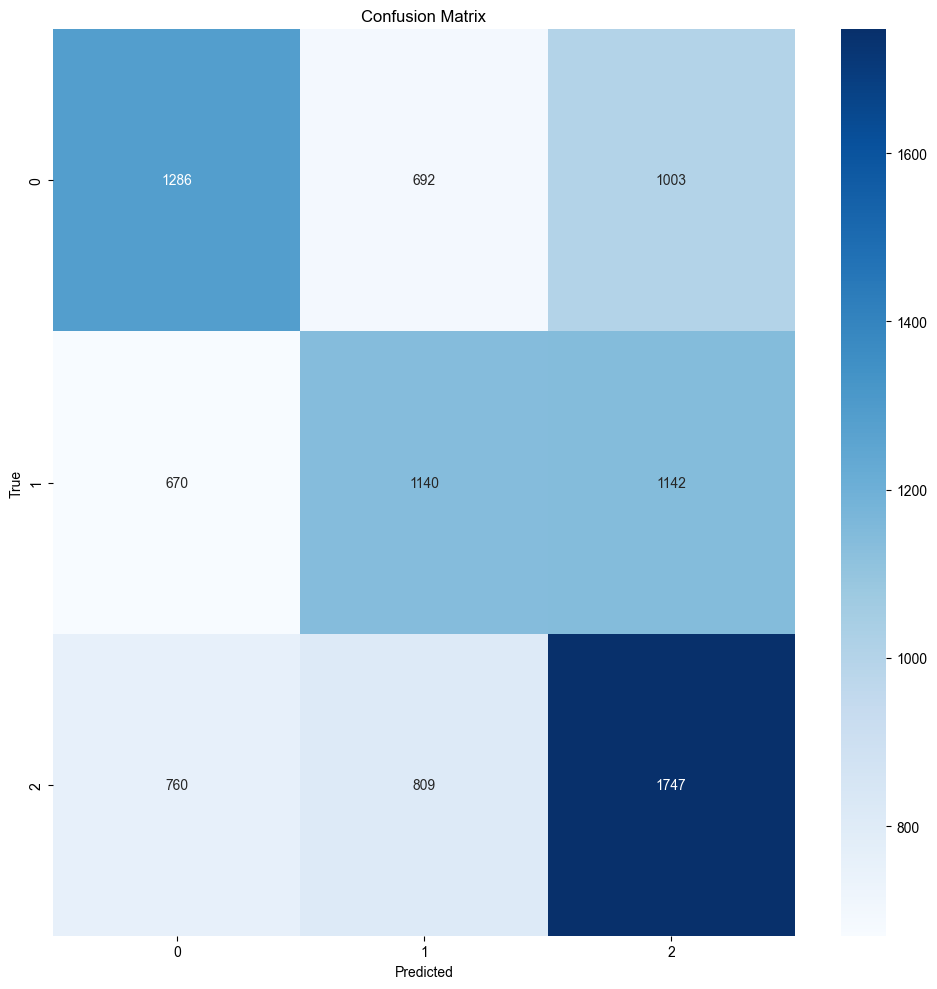

In [27]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
if task == "employee":
    preds = data["c2v"]['prb'].argmax(axis=1)
    target = data["c2v"]['trg']
    cm = confusion_matrix(target, preds)

    # plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path + "confusion_matrix.png", format="png")

In [29]:
# value counts of preds
pd.Series(preds).value_counts(normalize=True) 

2    0.420802
0    0.293653
1    0.285544
dtype: float64

In [24]:
data

{'c2v': {'prb': array([[0.8221435 , 0.04648597, 0.13137054],
         [0.35457405, 0.40512395, 0.24030195],
         [0.3975347 , 0.3927556 , 0.20970972],
         ...,
         [0.7501078 , 0.05861341, 0.19127873],
         [0.39158463, 0.3725937 , 0.2358217 ],
         [0.40208232, 0.18189906, 0.41601855]], dtype=float32),
  'trg': array([0., 2., 2., ..., 0., 2., 1.], dtype=float32),
  'id': array([10003369, 10005523, 10006120, ..., 89956528, 89989019, 92405451]),
  'auc': 0.6343560814857483,
  'mcc': {'mean': 0.1734258085489273,
   'lower': 0.15851093381643294,
   'upper': 0.18850365914404393},
  'f1': {'mean': 0.4479524493217468,
   'lower': 0.4379439249634743,
   'upper': 0.4580059707164764},
  'precision': {'mean': 0.45133817195892334,
   'lower': 0.441195584833622,
   'upper': 0.4616219520568848},
  'recall': {'mean': 0.4481390714645386,
   'lower': 0.43822058439254763,
   'upper': 0.4581475451588631}}}